<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/%ED%95%AD%EB%A1%9C_%ED%91%9C%EC%A7%80_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9D%B4%EC%83%81_%ED%83%90%EC%A7%80_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm # statsmodels 호출 
import seaborn as sns # 그래프를 그리기위한 Seaborn 호출 

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
dataframe = pd.read_csv('./drive/MyDrive/study/tmp_TB_STATUS.csv')
raw_data = dataframe.values
dataframe.head()

,Unnamed: 0,MMAF_CODE,MMSI,COLCT_DT,REG_ANS,COMM_TYPE,LATITUDE,LONGITUDE,INSTALL_DT,LANTERN_STATUS,RACON_STATUS,BATTERY_STATUS,CHARGER_STATUS,SOLAR_STATUS,DATALOGGER_STATUS,SPARE_STATUS,MAIN_VOLT_STATUS,SUB_VOLT_STATUS,SOLAR_VOLT_STATUS,WIND_VOLT_STATUS,WAVE_VOLT_STATUS,CHARGER_VOLT_STATUS,BATTERY_VOLT_STATUS,SPARE_VOLT_STATUS,AIS_CURR_STATUS,LANTERN_CURR_STATUS,DATALOGGER_CURR_STATUS,SPARE_CURR_STATUS,WIND_SPEED_STATUS,WIND_DIRECT_STATUS,AIR_TEMPER_STATUS,HUMIDITY_STATUS,DEW_POINT_STATUS,AIR_PRESSURE_STATUS,HORIZON_VISIBL_STATUS,WATER_LEVEL_STATUS,CURRENT1_STATUS,CURRENT2_STATUS,CURRENT3_STATUS,WAVE_HEIGHT_STATUS,WAVE_DRC_STATUS,SWELL_HEIGHT_STATUS,SWELL_DRC_STATUS,WATER_TEMPER_STATUS,PRECIPI_TYPE_STATUS,SALINITY_STATUS,ICE_STATUS,HEAT_PROSTR_STATUS,HELIOGRAPH_STATUS,OXYGEN_STATUS,OXYGEN_SATUR_STATUS,PH_STATUS,CHLOROPHYLL_STATUS,MUDDINESS_STATUS,PRECIPI_STATUS,CHARGER_CURR_STATUS,DISCHARGER_CURR_STATUS,VTS_ID,BASESTATION_ID,REGIST_USER_NO,REGIST_DT,UPDT_USER_NO,UPDT_DT
0,0,103,994403901,1.998030e+13,NaN,NaN,33.797717,126.322500,NaN,0,0,1,0.0,1.0,0.0,NaN,13.4,NaN,2.0,NaN,NaN,NaN,14.7,0.0,0.26,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.87,NaN,NaN,NaN,NaN,NaN,NaN
1,1,104,994401597,2.014030e+13,NaN,NaN,35.066583,129.130850,NaN,0,2,1,0.0,1.0,0.0,NaN,10.5,NaN,0.0,NaN,NaN,NaN,10.2,0.0,0.16,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.59,NaN,NaN,NaN,NaN,NaN,NaN
2,2,107,994402986,2.014020e+13,NaN,NaN,34.703650,125.837100,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,8.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,107,994402986,2.014020e+13,NaN,NaN,34.703667,125.837117,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,0.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.01,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,4,107,994402986,2.014020e+13,NaN,NaN,34.703667,125.837117,NaN,0,0,1,0.0,1.0,0.0,NaN,12.8,NaN,0.0,NaN,NaN,NaN,14.1,0.0,0.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN


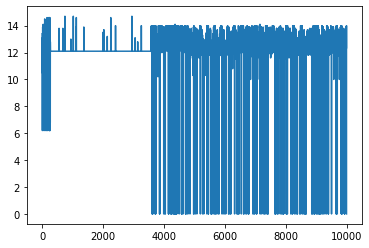

In [3]:
# The last element contains the labels

# The other data points are the electrocadriogram data
dataframe['MAIN_VOLT_STATUS'].plot()
tmp_data = dataframe['MAIN_VOLT_STATUS'][4000:10000]
data = np.reshape(np.array(tmp_data),(60,100))
np.nan_to_num(data,copy=False)
np.nan_to_num(tmp_data,copy=False)
labels = np.ones(60)




train_data, test_data, _, _ = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
print(min_val)
print(max_val)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(14.1, shape=(), dtype=float64)


In [6]:
normal_train_data = train_data
normal_test_data = test_data
_shape = np.shape(test_data)
anomalous_train_data = train_data
anomalous_test_data = test_data + np.random.rand(_shape[0],_shape[1])

(100,)


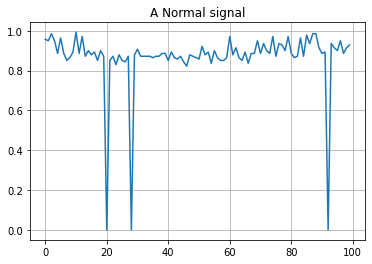

In [7]:
print(np.shape(normal_train_data[0]))
plt.grid()
plt.plot(np.arange(100), normal_train_data[0])
plt.title("A Normal signal")
plt.show()

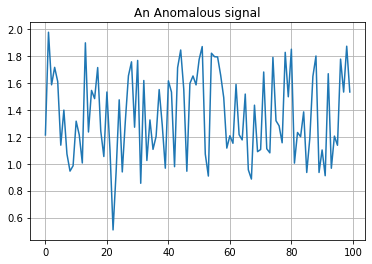

In [8]:
plt.grid()
plt.plot(np.arange(100), anomalous_test_data[0])
plt.title("An Anomalous signal")
plt.show()

In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(100, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(100, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=30,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
2/2 [==============================] - 2s 529ms/step - loss: 0.3988 - val_loss: 0.3919
Epoch 2/50
2/2 [==============================] - 0s 60ms/step - loss: 0.3933 - val_loss: 0.3841
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.3847 - val_loss: 0.3724
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 0.3718 - val_loss: 0.3557
Epoch 5/50
2/2 [==============================] - 0s 47ms/step - loss: 0.3537 - val_loss: 0.3333
Epoch 6/50
2/2 [==============================] - 0s 57ms/step - loss: 0.3297 - val_loss: 0.3066
Epoch 7/50
2/2 [==============================] - 0s 56ms/step - loss: 0.3020 - val_loss: 0.2784
Epoch 8/50
2/2 [==============================] - 0s 60ms/step - loss: 0.2725 - val_loss: 0.2529
Epoch 9/50
2/2 [==============================] - 0s 57ms/step - loss: 0.2468 - val_loss: 0.2328
Epoch 10/50
2/2 [==============================] - 0s 55ms/step - loss: 0.2256 - val_loss: 0.2142
Epoch 11/50
2/2 [===========

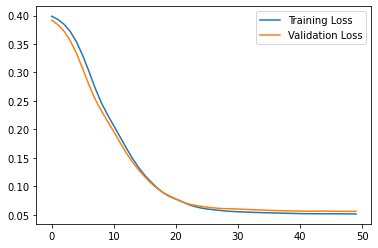

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()



In [14]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()


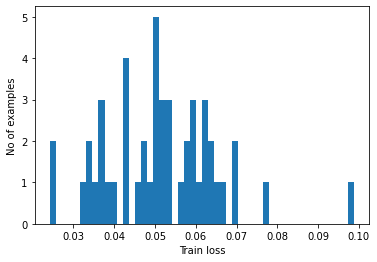

In [15]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.065197766


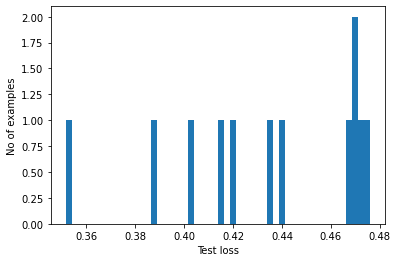

In [17]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

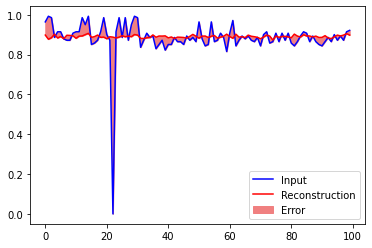

In [20]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(100), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

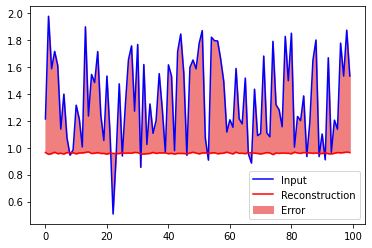

In [21]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(100), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()